In [ ]:
import pandas as pd
import numpy as np

##Importing libraries and data

I read the data in chunks and here I combined all 17 chunks.

In [ ]:
df1=pd.read_csv("sevenchunks1.csv")
df2=pd.read_csv("tenchunks.csv")

Only these 2 columns are necessary for our model

In [ ]:
df2.head()

,FIRSTOCCURRENCE,SUMMARY
0,2020-04-23 09:40:11,VPLS VC Down
1,2020-04-23 09:40:11,VPLS VC Down
2,2020-04-21 10:30:31,Physical Port Down
3,2020-04-21 10:30:36,Link Down
4,2020-04-21 10:53:17,The optical module is removed


In [ ]:
df1.head()

,FIRSTOCCURRENCE,SUMMARY
0,2020-12-02 04:55:50,VPLS VC Down
1,2020-12-02 04:55:55,VPLS VC Down
2,2020-12-02 04:55:49,VPLS VC Down
3,2020-12-02 04:55:50,VPLS VC Down
4,2020-12-02 04:55:49,VPLS VC Down


In [ ]:
df2=df2[["FIRSTOCCURRENCE", "SUMMARY"]]
df2["FIRSTOCCURRENCE"]=pd.to_datetime(df2.FIRSTOCCURRENCE)

In [ ]:
df_final=pd.concat([df2, df1])

In [ ]:
df_final["FIRSTOCCURRENCE"]=pd.to_datetime(df_final.FIRSTOCCURRENCE)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8037683 entries, 0 to 3037682
Data columns (total 2 columns):
 #   Column           Dtype         
---  ------           -----         
 0   FIRSTOCCURRENCE  datetime64[ns]
 1   SUMMARY          object        
dtypes: datetime64[ns](1), object(1)
memory usage: 184.0+ MB


In [ ]:
df_final["hour"]=df_final.FIRSTOCCURRENCE.dt.hour

In [ ]:
df_final["seconds"]=df_final.FIRSTOCCURRENCE.dt.second

In [ ]:
df_final["firstoccurence"]=df_final["FIRSTOCCURRENCE"].dt.date

Here I created a database on a weekly basis. I used summary columns and counted the weekly events and rename the columns as Num_Failures (number of weekly failures)

In [ ]:
newdf2= df_final.set_index("FIRSTOCCURRENCE", drop=True).resample('W').agg({"SUMMARY":"count"}).rename(columns=({"SUMMARY":"Num_Failures"}))

In [ ]:
newdf2.head()

,Num_Failures
FIRSTOCCURRENCE,
2016-11-27,831
2016-12-04,8290
2016-12-11,0
2016-12-18,0
2016-12-25,0


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
newdf2.describe()

,Num_Failures
count,225.000
mean,35717.542
std,279955.737
min,0.000
25%,0.000
50%,834.000
75%,8380.000
max,4108073.000


As seen from the data almost half of the weeks, there is no failures. However for some week the number is very high. (as high as 410873). It shows that the data is inconsistent. Fluctuation is huge. Since there is no occurence of failures for some weeks, these weeks have a value of 0.

In [ ]:
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [ ]:
pd.plotting.register_matplotlib_converters()

In [ ]:
df = newdf2.reset_index()

In [ ]:
df=df.rename(columns={'FIRSTOCCURRENCE':'ds', 'Num_Failures':'y'})
df.head()

,ds,y
0,2016-11-27,831
1,2016-12-04,8290
2,2016-12-11,0
3,2016-12-18,0
4,2016-12-25,0


In [ ]:
df[df.y==0].count()

ds    100
y     100
dtype: int64

In [ ]:
df.shape

(225, 2)

As seen from above, we have 225 weeks and almost half of them (100) are with a value of 0. This reduces the accuracy of the prediction.

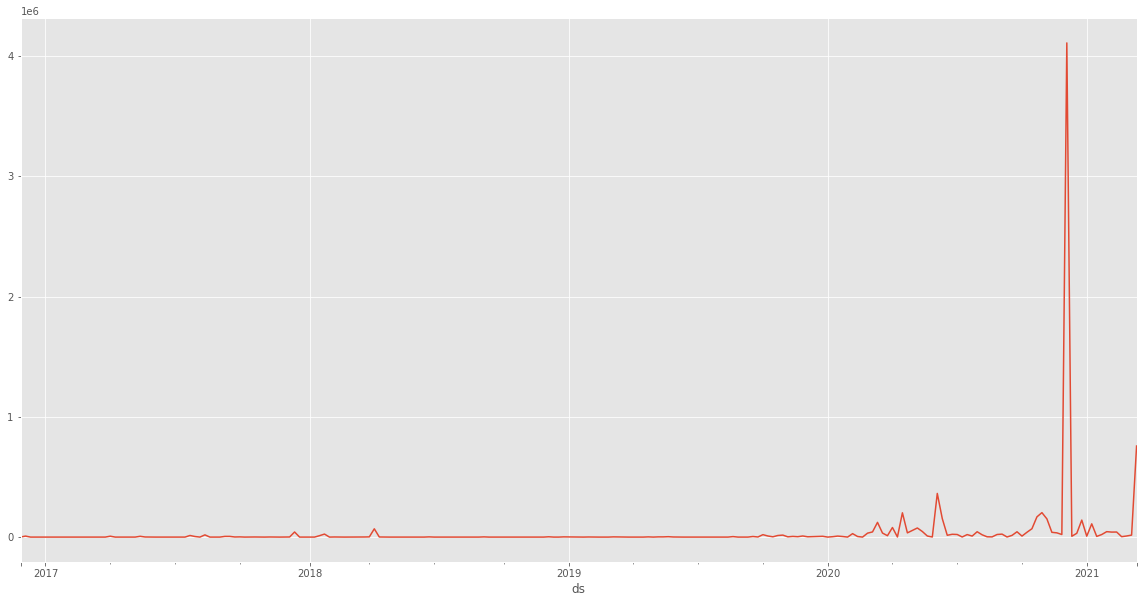

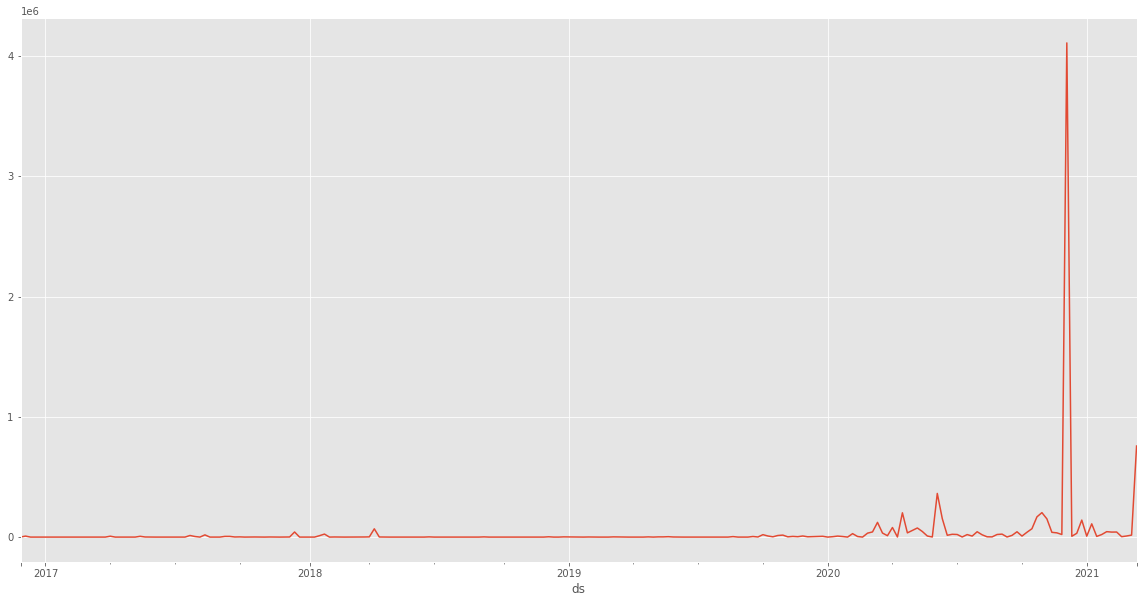

In [ ]:
df.set_index('ds').y.plot().figure

Fluctuation can be seen here. After 2020, the number of failures increases enormously.

In [ ]:
model = Prophet()

In [ ]:
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#future = list()
#for i in range(1, 13):
	#date = '2020-%02d' % i
	#future.append([date])
#future = pd.DataFrame(future)
#future.columns = ['ds']
future = model.make_future_dataframe(periods=52, freq = 'w')
future.tail()

,ds
272,2022-02-13
273,2022-02-20
274,2022-02-27
275,2022-03-06
276,2022-03-13


In [ ]:
forecast = model.predict(future)

In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds           yhat     yhat_lower     yhat_upper
272 2022-02-13  211005.441692 -103070.290564  578042.086778
273 2022-02-20  230525.447012 -111367.568991  557184.348317
274 2022-02-27  238030.158779  -74094.155277  581821.831854
275 2022-03-06  249548.238444  -87584.115227  595225.144765
276 2022-03-13  279532.789488  -48049.788755  624273.846655


Predictions for the year 2020 can be seen above. yhat show the predicted amount of failure in that spesific week, yhatlower and yhatupper are the lower and upper limits.

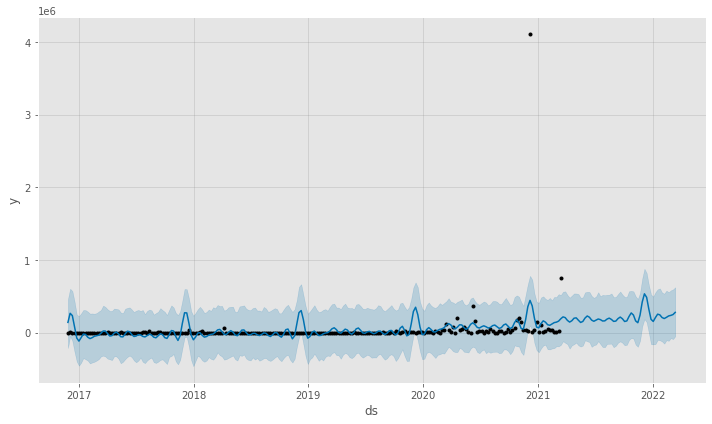

In [ ]:
# plot forecast
model.plot(forecast)
plt.show()

As seen above trend is increasing and 2021 data kind of ruins the predictions due to huge number of failures.

**Below is the monthly prediction.**

In [ ]:
monthdf= df_final.set_index("FIRSTOCCURRENCE", drop=True).resample('M').agg({"SUMMARY":"count"}).rename(columns=({"SUMMARY":"Num_Failures"}))

In [ ]:
#monthdf.loc[monthdf.Num_Failures >= monthdf.Num_Failures.mean(), "Num_Failures"]=monthdf.Num_Failures.mean()

In [ ]:
df21 = monthdf.reset_index()

In [ ]:
df21=df21.rename(columns={'FIRSTOCCURRENCE':'ds', 'Num_Failures':'y'})
df21.head()

,ds,y
0,2016-11-30,9121
1,2016-12-31,0
2,2017-01-31,0
3,2017-02-28,0
4,2017-03-31,7528


In [ ]:
df21[df21.y==0].count()

ds    10
y     10
dtype: int64

In [ ]:
df21.shape

(53, 2)

Here we have 53 months and 10 of them do not have values.

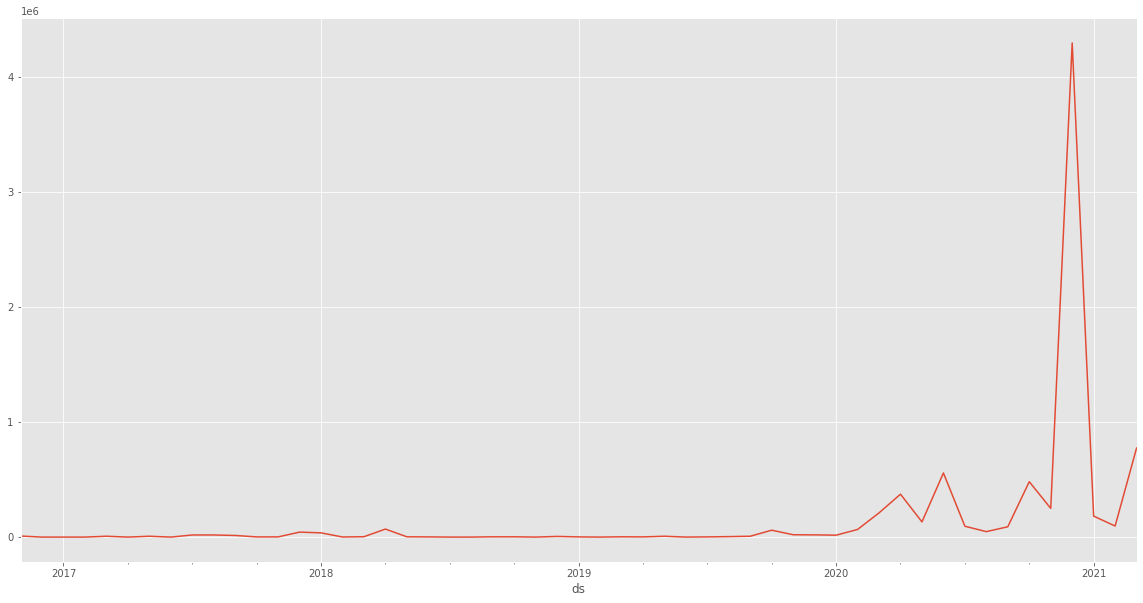

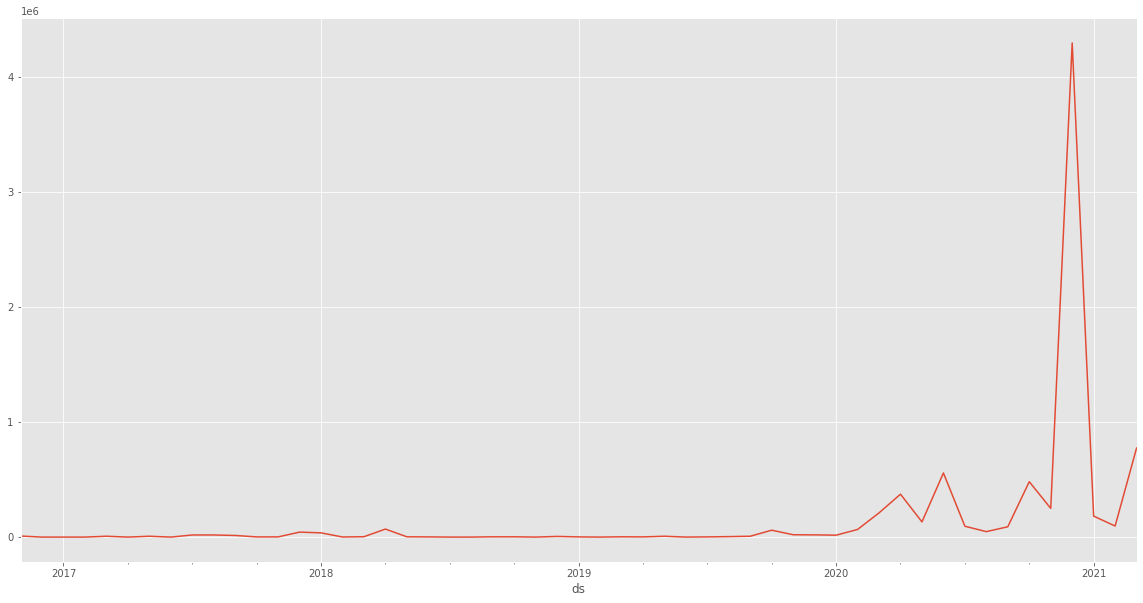

In [ ]:
df21.set_index('ds').y.plot().figure

In [ ]:
model = Prophet()
model.fit(df21)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=12, freq = 'M')
future.tail()

,ds
60,2021-11-30
61,2021-12-31
62,2022-01-31
63,2022-02-28
64,2022-03-31


In [ ]:
forecast = model.predict(future)

In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

           ds          yhat     yhat_lower    yhat_upper
60 2021-11-30  5.884053e+05   35180.908437  1.158738e+06
61 2021-12-31  1.537598e+06  987496.213572  2.088717e+06
62 2022-01-31  5.590917e+05   17286.481362  1.123723e+06
63 2022-02-28  7.262849e+05  195952.912955  1.243439e+06
64 2022-03-31  7.755756e+05  241034.337164  1.325484e+06


Monthly predictions can be seen above.

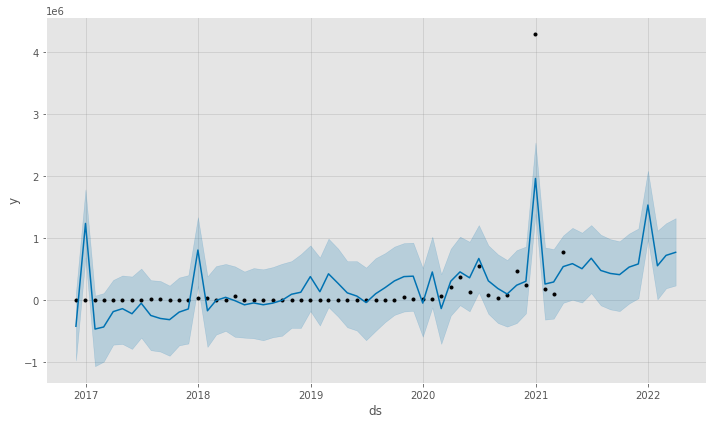

In [ ]:
# plot forecast
model.plot(forecast)
plt.show()

In [ ]:
from fbprophet.diagnostics import cross_validation

In [ ]:
cv_results=cross_validation(model, horizon= "360 days" )

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-04-05 00:00:00 and 2020-04-05 00:00:00


In [ ]:

def mean_absolute_percentage_error(y_true,y_pred):
  y_true, y_pred=np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [ ]:
mape_baseline=mean_absolute_percentage_error(cv_results.y, cv_results.yhat)

In [ ]:
mape_baseline

79.85154901286103

In [ ]:
future2 = list()
for i in range(1, 13):
	date = '2018-01-%02d' % i
	future2.append([date])
future2 = pd.DataFrame(future)
future2.columns = ['ds']

In [ ]:
future2.head()

,ds
0,2020-01
1,2020-02
2,2020-03
3,2020-04
4,2020-05


In [ ]:
prediction = model.predict(future2)

In [ ]:
print(prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

           ds           yhat     yhat_lower     yhat_upper
7  2020-08-01  421464.907207 -148465.445437  984457.517697
8  2020-09-01  -14446.603778 -583254.644054  538822.622713
9  2020-10-01 -409849.706154 -980666.747312  168693.379038
10 2020-11-01 -225079.843258 -776319.670644  317242.131875
11 2020-12-01 -182026.504616 -754827.730812  347228.629026


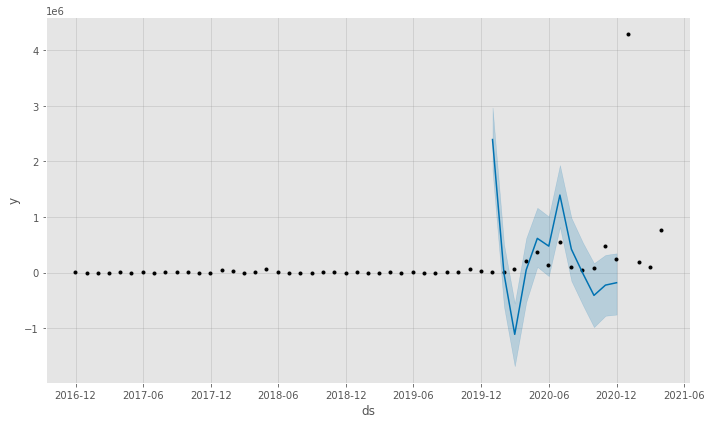

In [ ]:
model.plot(prediction)
plt.show()